# Piece classification


## Data

Labelized by challenger

|column|value|
|------|-----|
|document_id|Document id in database|
|first_page|Only the text content of first page for each document|
|label|Label of especialists|

Dump date

* 27-06-2018
* 26-06-2018

Dataset's proportions:

* 70% train
* 20% validation
* 10% test

## Configuração

 
* pip3 install sklearn;
* pip3 install seaborn;
* pip3 install matplotlib;
* pip3 install pandas;
* pip3 install numpy;
* pip3 install paramiko;
* pip3 install jupyter notebook;
* pip3 install joblib;
* pip3 install tensorflow
* pip3 install keras

# Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy as sp
import numpy as np
import paramiko
import os
import multiprocessing
import tensorflow as tf
import joblib

from keras.utils import multi_gpu_model
from keras.utils import np_utils, to_categorical, plot_model
from keras.models import Sequential, load_model, Model
from keras.engine import Input
from keras.layers import (
    Embedding, BatchNormalization,
    LSTM, SimpleRNN, GRU, RNN, CuDNNLSTM,
    Conv1D, MaxPooling1D,
    Bidirectional, Concatenate, merge,
    Dense, Flatten, Dropout, Activation, Lambda, Reshape
)
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, TerminateOnNaN, TensorBoard
from keras.backend.tensorflow_backend import set_session
from keras.metrics import categorical_accuracy, binary_accuracy

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score,
    recall_score, precision_recall_fscore_support, f1_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from nltk.corpus import stopwords
from scipy.special import comb

from tqdm import tqdm

from IPython.display import display, HTML

SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

NameError: name 'tf' is not defined

# Models

Assure the model dir exist

In [1]:
model_path = '~/Projects/ai/stf_fga/peca_models/'

In [4]:
def save_model(model, model_name=None):
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    if model_name == None:
        model_name = 'model-'+ '-'.join([x['class_name'][:3] for x in model.get_config()]) + '.h5'
        model_name = model_name.lower()
    path = os.path.join(model_path, model_name)
    model.save(path)

# Dataset

In [5]:
# # import json from NAS
# host = "nas.lades.unb.br"
# port = 22
# transport = paramiko.Transport((host, port))

# password="L@desehet"
# username="hehet"
# transport.connect(username=username, password=password)
# sftp = paramiko.SFTPClient.from_transport(transport)

In [6]:
# path_train='/mnt/lvm/lvm_array2/lvm101_GPAM/Pecas/27-06-2018/27-06-2018-Treino-Tag-pre-processed.csv'
# file_csv = sftp.file(path_train)
# train = pd.read_csv(file_csv, usecols=['label', 'text', 'text_pre_processed'])

# path_test='/mnt/lvm/lvm_array2/lvm101_GPAM/Pecas/27-06-2018/27-06-2018-Teste-Tag-pre-processed.csv'
# file_csv = sftp.file(path_test)
# test = pd.read_csv(file_csv, usecols=['label', 'text', 'text_pre_processed'])

# path_validation='/mnt/lvm/lvm_array2/lvm101_GPAM/Pecas/27-06-2018/27-06-2018-Validacao-Tag-pre-processed.csv'
# file_csv = sftp.file(path_validation)
# validation = pd.read_csv(file_csv, usecols=['label', 'text', 'text_pre_processed'])

train = pd.read_csv('data/train-27-06-2018-wo-duplicates.csv')
validation = pd.read_csv('data/validation-27-06-2018-wo-duplicates.csv')
test = pd.read_csv('data/test-27-06-2018-wo-duplicates.csv')

In [7]:
train = train[(train.label != 'D. Agrav') & (train.label != 'P. Agrav')]
test = test[(test.label != 'D. Agrav') & (test.label != 'P. Agrav')]
validation = validation[(validation.label != 'D. Agrav') & (validation.label != 'P. Agrav')]

labels_index = train.label.value_counts().index.sort_values()

label_train = train.label.value_counts()[labels_index]
label_validation = validation.label.value_counts()[labels_index]
label_test = test.label.value_counts()[labels_index]
labels = (test.label.value_counts() + validation.label.value_counts() + train.label.value_counts())[labels_index]
print("Train")
print(label_train[labels_index])
print("\nValidation")
print(label_validation[labels_index])
print("\nTeste")
print(label_test[labels_index])
print("\nTotal")
print(labels)
print("\nCount: ", labels.sum())

Train
ARE         892
Acordao     681
Desp.       393
Outro      2397
RE          430
Sent.       790
Name: label, dtype: int64

Validation
ARE        255
Acordao    195
Desp.      113
Outro      685
RE         123
Sent.      225
Name: label, dtype: int64

Teste
ARE        127
Acordao     97
Desp.       56
Outro      342
RE          62
Sent.      113
Name: label, dtype: int64

Total
ARE        1274
Acordao     973
Desp.       562
Outro      3424
RE          615
Sent.      1128
Name: label, dtype: int64

Count:  7976


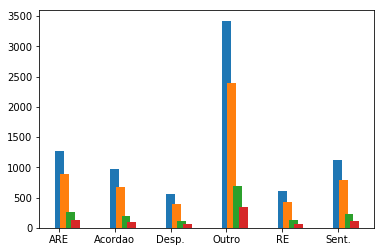

In [8]:
ind = np.arange(labels_index.size)
labels_legend = ['total', 'train', 'validation', 'test']
width = 0.16
plt.bar(ind + 0, labels, width=width)
plt.bar(ind + 0.1, label_train, width=width)
plt.bar(ind + 0.2, label_validation, width=width)
plt.bar(ind + 0.3, label_test, width=width)
x = plt.xticks(ind, labels_index)

#     plots.append(plot)
# plt.legend(plot, labels)


In [9]:
# Plot
# fig = plt.figure(figsize=(15,10))
# plot_train = fig.add_subplot(2, 2, 1, title="Train")
# plot_test = fig.add_subplot(2, 2, 2, title="Test")
# plot_validation = fig.add_subplot(2, 2, 3, title="Validation")
# sns.countplot(train['label'], ax=plot_train)
# sns.countplot(test['label'], ax=plot_test)
# x = sns.countplot(validation['label'], ax=plot_validation)

In [10]:
# Plot
# plt.figure(figsize=(10,10));   
# sns.countplot(train['label'])
# plt.show()

# plt.figure(figsize=(10,10));   
# sns.countplot(test['label'])
# plt.show()

# plt.figure(figsize=(10,10));   
# sns.countplot(validation['label'])
# plt.show()

# Network params

In [11]:
# Macro feactures
# MAX_FEATURES = 10000
MAX_FEATURES = 70000  # Size of vocabulary
EMBEDDING_DIM = MAX_FEATURES  # Size of vocabulary
SEQUENCE_LEN = 2000 # Size of input arrays
#SEQUENCE_LEN = 100
BATCH_SIZE = 32  # Base multiplier to batch train data
NB_CLASS = train.label.unique().size  # Number of output classes
UNITS = 100  # Number of output cells for Recurrent Models
EMBEDDING_OUT = 100  # Output dim of embedding
EPOCHS = 5  # Number of rounds

## Stop early

In [12]:
early_stop = EarlyStopping(patience=3, min_delta=0.01, verbose=1, monitor='val_acc')
# board = TensorBoard(log_dir='./log')
callbacks = [early_stop, ]

# Data transform

## X values

In [13]:
# Tokenize x axis
print('Vocabulary size:')

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train['first_page'])
sequences_train = tokenizer.texts_to_sequences(train['first_page'])
sequences_validation = tokenizer.texts_to_sequences(validation['first_page'])
sequences_test = tokenizer.texts_to_sequences(test['first_page'])
print('\tnon processed', len(tokenizer.word_counts))

# tokenizer = Tokenizer(num_words=MAX_FEATURES)
# tokenizer.fit_on_texts(train['text_pre_processed'])
# sequences_train_processed = tokenizer.texts_to_sequences(train['text_pre_processed'])
# sequences_validation_processed = tokenizer.texts_to_sequences(validation['text_pre_processed'])
# sequences_test_processed = tokenizer.texts_to_sequences(test['text_pre_processed'])
# print('\tprocessed', len(tokenizer.word_counts))

Vocabulary size:
	non processed 50107


In [14]:
if not os.path.exists(model_path):
    os.mkdir(model_path)
joblib.dump(tokenizer, os.path.join(model_path, 'text-tokenizer.pkl'))

['/home/marcelohpf/unb/tcc/models/text-tokenizer.pkl']

### Padding

In [15]:
# Equalizing the len of matriz
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(sequences_train, maxlen=SEQUENCE_LEN, padding='post')
X_test = sequence.pad_sequences(sequences_test, maxlen=SEQUENCE_LEN, padding='post')
X_validation = sequence.pad_sequences(sequences_validation, maxlen=SEQUENCE_LEN, padding='post')

# X_train_processed = sequence.pad_sequences(sequences_train_processed, maxlen=SEQUENCE_LEN, padding='post')
# X_test_processed = sequence.pad_sequences(sequences_test_processed, maxlen=SEQUENCE_LEN, padding='post')
# X_validation_processed = sequence.pad_sequences(sequences_validation_processed, maxlen=SEQUENCE_LEN, padding='post')

print('\tNon processed')
print('\t\tX_train shape:', X_train.shape)
print('\t\tX_test shape:', X_test.shape)
print('\t\tX_validation shape:', X_validation.shape)

# print("\tProcessed")
# print('\t\tX_train shape:', X_train_processed.shape)
# print('\t\tX_test shape:', X_test_processed.shape)
# print('\t\tX_validation shape:', X_validation_processed.shape)

Pad sequences (samples x time)
	Non processed
		X_train shape: (5583, 2000)
		X_test shape: (797, 2000)
		X_validation shape: (1596, 2000)


## Signal form

mean: 265.20 +- 117.51
max:  1029
min:  30
median:  239.0


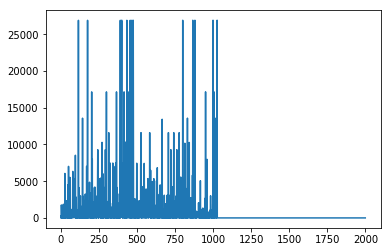

In [16]:
signal_sizes = np.count_nonzero(X_train, axis=1)
bigger_signal = signal_sizes.argmax()
plt.plot(X_train[bigger_signal])
print("mean: {:.2f} +- {:.2f}".format(np.mean(signal_sizes), np.std(signal_sizes)))
print("max: ", np.max(signal_sizes))
print("min: ", np.min(signal_sizes))
print("median: ", np.median(signal_sizes))

## Labels

In [17]:
# Label the y axis

lb = LabelBinarizer()
Y_train = lb.fit_transform(train['label'])
Y_test = lb.transform(test['label'])
Y_validation = lb.transform(validation['label'])
lb.classes_

array(['ARE', 'Acordao', 'Desp.', 'Outro', 'RE', 'Sent.'], dtype='<U7')

In [18]:
joblib.dump(lb, os.path.join(model_path, 'label-binarizer.pkl'))

['/home/marcelohpf/unb/tcc/models/label-binarizer.pkl']

In [19]:
# lb = joblib.load(os.path.join(model_path, 'label-binarizer.pkl'))

# Report

Plot a normalized matrix

In [20]:
def report(y, y_hat, lb=None, history=None, classes=None):
    if lb is None and classes is None:
        raise Exception('Labelizer or classes should be passed')
        
    if lb:
        y, y_hat = lb.inverse_transform(y), lb.inverse_transform(y_hat)
        classes = lb.classes_
    
    cm = confusion_matrix(y, y_hat)
    ncm = cm / cm.max(axis=1)[:, None]

    print(classification_report(y, y_hat, target_names=classes))
    print('Accuracy: ', accuracy_score(y, y_hat))

    
    plt.title('confusion matrix')
    heatmap = sns.heatmap(pd.DataFrame(ncm, index=classes, columns=classes), annot=cm, fmt='d', cmap=sns.cubehelix_palette(light=1, as_cmap=True))
    plt.show()
    if history:
        plt.subplot(2, 1, 1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.subplot(2, 1, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

# Base lines

## SVM

https://www.aclweb.org/anthology/P12-2018

### Bag of words

In [21]:
cv = CountVectorizer(max_features=MAX_FEATURES, vocabulary=list(tokenizer.word_index.keys()))
cv.fit(train.first_page)

assert len(cv.vocabulary_) == len(tokenizer.word_index), "The size of two text transformers aren't equal"

len(cv.vocabulary_), len(tokenizer.word_index)

(50107, 50107)

In [22]:
X_train_bow = cv.transform(train.first_page)
X_validation_bow = cv.transform(validation.first_page)
X_test_bow = cv.transform(test.first_page)
X_train_bow.shape, X_validation_bow, X_test_bow

((5583, 50107), <1596x50107 sparse matrix of type '<class 'numpy.int64'>'
 	with 250538 stored elements in Compressed Sparse Row format>, <797x50107 sparse matrix of type '<class 'numpy.int64'>'
 	with 123819 stored elements in Compressed Sparse Row format>)

### Labels

In [23]:
le = LabelEncoder()
YY_train = le.fit_transform(train.label)
YY_validation = le.transform(validation.label)
YY_test = le.transform(test.label)

### Train

In [24]:
clf = SVC(max_iter=10000, verbose=True, class_weight='balanced')
clf.fit(X_train_bow, YY_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

### Processed

/home/marcelohpf/unb/tcc/.env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marcelohpf/unb/tcc/.env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

        ARE       0.74      0.72      0.73       127
    Acordao       0.71      0.57      0.63        97
      Desp.       0.74      0.70      0.72        56
      Outro       0.83      0.68      0.75       342
         RE       0.44      0.95      0.61        62
      Sent.       0.74      0.88      0.80       113

avg / total       0.75      0.72      0.73       797

Accuracy:  0.7214554579673776


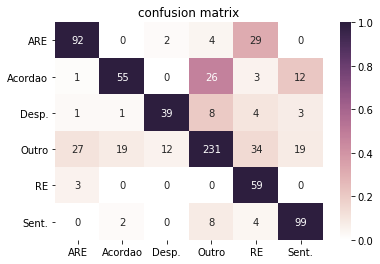

In [25]:
clf.score(X_validation_bow, YY_validation)

preds = clf.predict(X_test_bow)
report(YY_test, preds, le)

# NN

## Dense

In [26]:
# # Build model
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
# model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(NB_CLASS, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
#

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         7000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 200000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                4000020   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 11,000,146
Trainable params: 11,000,146
Non-trainable params: 0
_________________________________________________________________


Train on 5583 samples, validate on 1596 samples
Epoch 1/10
5583/5583 [==============================] - 12s 2ms/step - loss: 1.2844 - acc: 0.6814 - val_loss: 0.4496 - val_acc: 0.8565
Epoch 2/10
5583/5583 [==============================] - 11s 2ms/step - loss: 0.1235 - acc: 0.9681 - val_loss: 0.4157 - val_acc: 0.8615
Epoch 3/10
5583/5583 [==============================] - 11s 2ms/step - loss: 0.0358 - acc: 0.9941 - val_loss: 0.3889 - val_acc: 0.8828
Epoch 4/10
5583/5583 [==============================] - 11s 2ms/step - loss: 0.0201 - acc: 0.9968 - val_loss: 0.3955 - val_acc: 0.8791
Epoch 5/10
5583/5583 [==============================] - 11s 2ms/step - loss: 0.0198 - acc: 0.9971 - val_loss: 0.4127 - val_acc: 0.8816
Epoch 6/10
5583/5583 [==============================] - 11s 2ms/step - loss: 0.0249 - acc: 0.9970 - val_loss: 0.4017 - val_acc: 0.8841
Epoch 00006: early stopping
797/797 [==============================] - 0s 178us/step
             precision    recall  f1-score   support

   

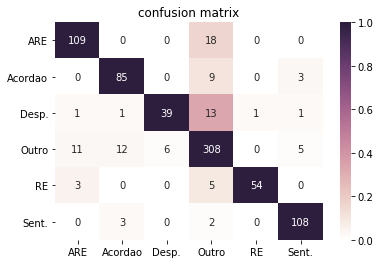

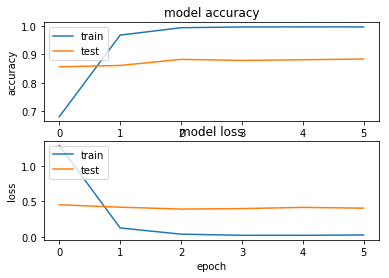

In [27]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS*2,
          validation_data=(X_validation, Y_validation), callbacks=callbacks)

pred = model.predict(X_test, verbose=1)

report(Y_test, pred, lb, history)

## Convolutional

In [28]:
# filters_size = [512, 256, 128, 64]
# Very Deep Convolutional Networks for Text Classification
# Build model
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

model.add(Conv1D(kernel_size=4, filters=256, padding='same',))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(NB_CLASS, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 100)         7000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 256)         102656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1536006   
Total params: 8,638,662
Trainable params: 8,638,662
Non-trainable params: 0
_________________________________________________________________


### Non-processed

Train on 5583 samples, validate on 1596 samples
Epoch 1/10
5583/5583 [==============================] - 31s 6ms/step - loss: 1.0003 - acc: 0.6217 - val_loss: 0.4167 - val_acc: 0.8640
Epoch 2/10
5583/5583 [==============================] - 30s 5ms/step - loss: 0.2076 - acc: 0.9361 - val_loss: 0.3510 - val_acc: 0.8866
Epoch 3/10
5583/5583 [==============================] - 30s 5ms/step - loss: 0.0623 - acc: 0.9866 - val_loss: 0.3631 - val_acc: 0.8904
Epoch 4/10
5583/5583 [==============================] - 30s 5ms/step - loss: 0.0260 - acc: 0.9934 - val_loss: 0.3921 - val_acc: 0.8860
Epoch 5/10
5583/5583 [==============================] - 30s 5ms/step - loss: 0.0190 - acc: 0.9957 - val_loss: 0.4013 - val_acc: 0.8966
Epoch 6/10
5583/5583 [==============================] - 30s 5ms/step - loss: 0.0123 - acc: 0.9970 - val_loss: 0.4061 - val_acc: 0.8954
Epoch 7/10
5583/5583 [==============================] - 30s 5ms/step - loss: 0.0115 - acc: 0.9975 - val_loss: 0.4347 - val_acc: 0.8891
Epoch 8

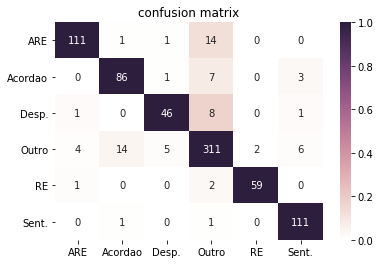

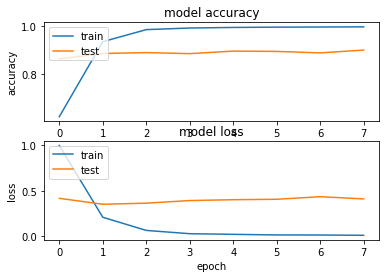

In [29]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE*2, epochs=EPOCHS * 2,
          validation_data=(X_validation, Y_validation), callbacks=callbacks)

pred = model.predict(X_test, verbose=1)

report(Y_test, pred, lb, history)

### Processed

In [ ]:
history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS * 2,
          validation_data=(X_validation_processed, Y_validation), callbacks=callbacks)

score, acc = model.evaluate(X_test_processed, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)
pred = model.predict(X_test_processed, verbose=1)

report(Y_test, pred, lb, history)

### Save model

Save the model in path of models

In [1]:
# save_model(model, 'model-emb-conv1layer-dense.h5')

## LSTM

In [2]:
# model = Sequential()
# model.add(Embedding(input_dim=EMBEDDING_DIM, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
# model.add(CuDNNLSTM(units=UNITS))
# # model.add(Dropout(0.5))
# # model.add(Dense(64, activation='relu'))
# # model.add(Flatten())
# model.add(Dense(NB_CLASS, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()

In [ ]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE * 2, epochs=EPOCHS,
          validation_data=(X_validation, Y_validation), callbacks=callbacks)

pred = model.predict(X_test, verbose=1)

report(Y_test, pred, lb, history)

## Bi-LSTM

In [30]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
model.add(Bidirectional(CuDNNLSTM(units=UNITS*2), merge_mode='sum'))  # Use CuDNNLSTM to use in GPU
# model.add(Dense(64, activation='relu'))
model.add(Dense(NB_CLASS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 100)         7000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               483200    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1206      
Total params: 7,484,406
Trainable params: 7,484,406
Non-trainable params: 0
_________________________________________________________________


### Nonprocessed

Train on 5583 samples, validate on 1596 samples
Epoch 1/10
5583/5583 [==============================] - 180s 32ms/step - loss: 1.0270 - acc: 0.5931 - val_loss: 0.6271 - val_acc: 0.7343
Epoch 2/10
5583/5583 [==============================] - 181s 32ms/step - loss: 0.5704 - acc: 0.7654 - val_loss: 0.6059 - val_acc: 0.7519
Epoch 3/10
5583/5583 [==============================] - 181s 32ms/step - loss: 0.4725 - acc: 0.8178 - val_loss: 0.5783 - val_acc: 0.7807
Epoch 4/10
5583/5583 [==============================] - 181s 32ms/step - loss: 0.2925 - acc: 0.8943 - val_loss: 0.5665 - val_acc: 0.8283
Epoch 5/10
5583/5583 [==============================] - 181s 33ms/step - loss: 0.1932 - acc: 0.9373 - val_loss: 0.5888 - val_acc: 0.8221
Epoch 6/10
5583/5583 [==============================] - 181s 32ms/step - loss: 0.1759 - acc: 0.9452 - val_loss: 0.5608 - val_acc: 0.8133
Epoch 7/10
5583/5583 [==============================] - 181s 32ms/step - loss: 0.1403 - acc: 0.9545 - val_loss: 0.6049 - val_acc: 

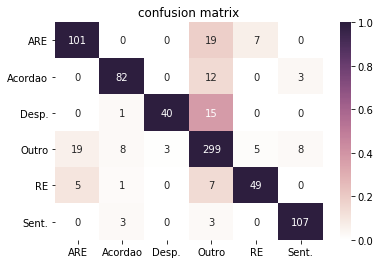

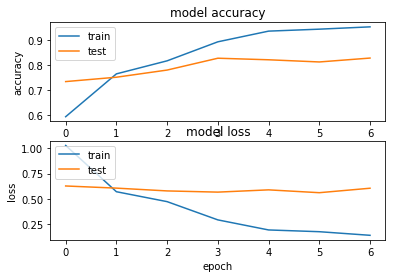

In [31]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE , epochs=EPOCHS * 2,
          validation_data=(X_validation, Y_validation), callbacks=callbacks)

pred = model.predict(X_test, verbose=1)

report(Y_test, pred, lb, history)

### Processed

In [ ]:
# history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS * 2,
#           validation_data=(X_validation_processed, Y_validation), callbacks=callbacks)

# score, acc = model.evaluate(X_test_processed, Y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test_processed, verbose=1)

# report(Y_test, pred, lb, history)

### Save model

Save the model in path of models

In [ ]:
# save_model(model, 'model-embe-bilstm-dense.h5')
# !ls models

Evaluate the process

In [ ]:
# model = load_model(os.path.join(model_path, 'model-embe-bilstm-dense.h5'))
# model.evaluate(X_test_processed, Y_test)

# Convolution architectures

## Very dense

In [ ]:
# model = Sequential([
#     Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN),
#     Conv1D(64, 3, padding="valid")
# ])

# # 4 pairs of convolution blocks followed by pooling
# for filter_size in [64, 128, 256, 512]:

#     # each iteration is a convolution block
#     for cb_i in [0,1]:
#         model.add(Conv1D(filter_size, 3, padding="same"))
#         model.add(BatchNormalization())
#         model.add(Activation("relu"))
#         model.add(Conv1D(filter_size, 3, padding="same")),
#         model.add(BatchNormalization())
#         model.add(Activation("relu"))

#     model.add(MaxPooling1D(pool_size=2, strides=3))

# # model.add(KMaxPooling(k=2))
# model.add(Flatten())
# model.add(Dense(4096, activation="relu"))
# model.add(Dense(2048, activation="relu"))
# model.add(Dense(2048, activation="relu"))
# model.add(Dense(NB_CLASS, activation="softmax"))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

### Processed

In [ ]:
# history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#           validation_data=(X_validation_processed, Y_validation))

# score, acc = model.evaluate(X_test_processed, Y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)
# pred = model.predict(X_test_processed, verbose=1)

# report(Y_test, pred, lb, history)

## Sentense classification

this models has the hyperparams of Gustavo from LL


In [ ]:
# text_seq_input = Input(shape=(SEQUENCE_LEN, ), dtype='int32')
# text_embedding = Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT,
#                            input_length=SEQUENCE_LEN)(text_seq_input)

# filter_sizes = [3, 4, 5]
# convs = []
# for filter_size in filter_sizes:
#     l_conv = Conv1D(filters=128, kernel_size=filter_size, padding='same', activation='relu')(text_embedding)
#     l_drop = Dropout(0.5)(l_conv)
#     l_pool = MaxPooling1D(filter_size + 1)(l_drop)
    
#     convs.append(l_pool)

# l_merge = Concatenate(axis=1)(convs)
# l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
# # since the text is too long we are maxpooling over 100
# # and not GlobalMaxPool1D
# l_pool1 = MaxPooling1D(100)(l_cov1)
# l_flat = Flatten()(l_pool1)
# l_dense = Dense(128, activation='relu')(l_flat)
# l_drop = Dropout(0.5)(l_dense)
# l_out = Dense(NB_CLASS, activation='softmax')(l_drop)
# model = Model(inputs=[text_seq_input], outputs=l_out)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

### Processed

In [ ]:
# history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE * 8, epochs=EPOCHS,
#           validation_data=(X_validation_processed, Y_validation))

# score, acc = model.evaluate(X_test_processed, Y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)
# pred = model.predict(X_test_processed, verbose=1)

# report(Y_test, pred, lb, history)

### Save model

Save the model in path of models

In [ ]:
# save_model(model, 'model-embe-sent_conv-dense.h5')
# !ls models

# RNN architectures

## Bi-LSTM

In [ ]:
# model = Sequential()
# model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

# model.add(Bidirectional(CuDNNLSTM(units=UNITS * 2), merge_mode='sum'))  # Use CuDNNLSTM to use in GPU

# model.add(Dense(64, activation='relu'))
# model.add(Dense(NB_CLASS, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()

### Processed

In [ ]:
# history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE * 4, epochs=EPOCHS,
#           validation_data=(X_validation_processed, Y_validation))

# score, acc = model.evaluate(X_test_processed, Y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test_processed, verbose=1)

# report(Y_test, pred, lb, history)

# Mixed architectures

## Bi-LSTM-Convolutional

https://dl.acm.org/citation.cfm?id=2886636

Use the convolutional layer to extract the most important features from texto to then, pass throught LSTM to identify context between data

In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

# model.add(Bidirectional(CuDNNLSTM(units=UNITS*2), merge_mode='sum'))  # Use CuDNNLSTM to use in GPU
# model.add(Reshape(target_shape=(UNITS, 2)))

# model.add(Conv1D(kernel_size=4, filters=256, activation='relu', ))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(NB_CLASS, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
# history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE * 4, epochs=EPOCHS,
#           validation_data=(X_validation, Y_validation))

# score, acc = model.evaluate(X_test, Y_test,
#                             batch_size=BATCH_SIZE)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test, verbose=1)

# report(Y_test, pred, lb, history)

## Bi-RNN Convolutional

In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

# model.add(Bidirectional(SimpleRNN(units=UNITS*2), merge_mode='sum'))

# model.add(Reshape(target_shape=(UNITS, 2, )))

# model.add(Conv1D(kernel_size=32, filters=4, activation='relu', ))
# model.add(MaxPooling1D(pool_size=2))


# model.add(Flatten())
# model.add(Dense(NB_CLASS, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
# history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS // 2,
#           validation_data=(X_validation, Y_validation))

# score, acc = model.evaluate(X_test, Y_test,
#                             batch_size=BATCH_SIZE)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test, verbose=1)

# report(Y_test, pred, lb, history)

## Convolutional Bi-RNN

In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

# # model.add(Conv1D(kernel_size=3, filters=256, activation='relu', padding='same'))
# model.add(Conv1D(kernel_size=4, filters=256, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(kernel_size=3, filters=128, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Bidirectional(SimpleRNN(units=UNITS*2), merge_mode='sum'))

# # model.add(Flatten())
# model.add(Dense(NB_CLASS, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
# history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#           validation_data=(X_validation, Y_validation))

# score, acc = model.evaluate(X_test, Y_test,
#                             batch_size=BATCH_SIZE)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test, verbose=1)

# report(Y_test, pred, lb, history)

## Convolutional Bi-LSTM

In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

# model.add(Conv1D(kernel_size=4, filters=512, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Bidirectional(CuDNNLSTM(units=UNITS * 2), merge_mode='sum'))

# # model.add(Flatten())
# model.add(Dense(NB_CLASS, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()

### Nonprocessed

In [ ]:
# history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#           validation_data=(X_validation, Y_validation))

# score, acc = model.evaluate(X_test, Y_test,
#                             batch_size=BATCH_SIZE)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test, verbose=1)

# report(Y_test, pred, lb, history)

### Processed

In [ ]:
# history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE * 4, epochs=EPOCHS * 2,
#           validation_data=(X_validation_processed, Y_validation))

# score, acc = model.evaluate(X_test_processed, Y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)

# pred = model.predict(X_test_processed, verbose=1)

# report(Y_test, pred, lb, history)

In [ ]:
# print('Build model...')
# model = Sequential()
# model.add(Embedding(max_features, 128, input_length=maxlen))
# model.add(LSTM(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(6, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()
# print('Train...')
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=3,
#           validation_data=(X_test, y_test))
# score, acc = model.evaluate(X_test, y_test,
#                             batch_size=batch_size)
# print('Test score:', score)
# print('Test accuracy:', acc)
# model.summary()

# Probabilities

## Data modification

In [ ]:
# Remove Outro to train a new model without this class
# ptrain = train[train.label != 'Outro']
# pvalidation = validation[validation.label != 'Outro']
# ptest = test[test.label != 'Outro']
# ptrain.label.value_counts()

In [ ]:
# Use same tokenization and padding. Assumes the vocabulary of Outros is know
# psequences_train = tokenizer.texts_to_sequences(ptrain.text_pre_processed)
# psequences_validation = tokenizer.texts_to_sequences(pvalidation.text_pre_processed)
# psequences_test = tokenizer.texts_to_sequences(ptest.text_pre_processed)

# PX_train = sequence.pad_sequences(psequences_train, maxlen=SEQUENCE_LEN, padding='post')
# PX_validation = sequence.pad_sequences(psequences_validation, maxlen=SEQUENCE_LEN, padding='post')
# PX_test = sequence.pad_sequences(psequences_test, maxlen=SEQUENCE_LEN, padding='post')

In [ ]:
# Label transformation

# plb = LabelBinarizer()
# PY_train = plb.fit_transform(ptrain.label)
# PY_validation = plb.transform(pvalidation.label)
# # Y test labels is unnecessary
# PY_test = plb.transform(ptest.label)

## Network params

In [ ]:
# PNB_CLASS = ptrain.label.unique().size  # Number of output classes

## Model

In [ ]:
# pmodel = Sequential()
# pmodel.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
# pmodel.add(Bidirectional(CuDNNLSTM(units=UNITS * 2), merge_mode='sum'))  # Use CuDNNLSTM to use in GPU
# # model.add(Dense(64, activation='relu'))
# pmodel.add(Dense(PNB_CLASS, activation='softmax'))

# pmodel.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# pmodel.summary()

### Processed

In [ ]:
# history = pmodel.fit(PX_train, PY_train, batch_size=BATCH_SIZE * 4, epochs=EPOCHS * 2,
#           validation_data=(PX_validation, PY_validation), callbacks=callbacks)

# pred = pmodel.predict(PX_test, verbose=1)

# report(PY_test, pred, plb, history)

### Predict probabilities

In [ ]:
# # model = load_model(os.path.join(model_path, 'model-bilstm-wo.outros.h5'))
# probabilities = pmodel.predict_proba(X_test_processed, verbose=1, batch_size=BATCH_SIZE * 16)

## Predict function

In [ ]:
def prob(y_hat, classes, threshold):
    idx = y_hat.argmax()
    if y_hat[idx] >= threshold:
            return classes[idx]
    return 'Outro'

def predict(y_pred, classes, threshold):
    return np.array([prob(y_hat, classes, threshold) for y_hat in y_pred])

def bad_prob(y_hat, classes, threshold):
    idx = y_hat.argmax()
    if y_hat[idx] >= threshold:
            return classes[idx]
    return None

def bad_evaluate(y_pred, classes, threshold, y_true):
    bad_result = []
    bad_y = []
    for y, y_hat in zip(y_true, y_pred):
        pred = bad_prob(y_hat, classes, threshold)
        if pred:
            bad_result.append(pred)
            bad_y.append(y)
#         else:
#             print(y, pred)
    
    return precision_recall_fscore_support(bad_y, bad_result, average='weighted')[:-1]
    

# precision_recall_fscore_support(y, y_hat, average='weighted')[:-1]

## Processed
### Threshold

In [ ]:
results = []
thresholds = np.arange(25, 101)/100
print(len(thresholds), thresholds)
for threshold in thresholds:
    predictions = predict(probabilities, plb.classes_, threshold)
    results.append(precision_recall_fscore_support(test.label, predictions, average='weighted')[:-1])

### Report

In [ ]:
results = np.array(results)
for metric in range(3):
    plt.plot(thresholds, results[:, metric])
plt.legend(['Precision', 'Recall', 'F-score'])
plt.xlabel('threshold')
plt.ylabel('metric value')
x = plt.yticks(np.arange(5, 20)/20)

### Bad

deleteme!!!

In [ ]:
results = []
for threshold in thresholds:
    result = bad_evaluate(probabilities, plb.classes_, threshold, test.label)
    results.append(result)

In [ ]:
results = np.array(results)
for metric in range(3):
    plt.plot(thresholds, results[:, metric])
plt.legend(['Precision', 'Recall', 'F-score'])
plt.xlabel('threshold')
plt.ylabel('metric value')
x = plt.yticks(np.arange(5, 20)/20)

# Ensamble

## Load models

Load and evaluate the best models

In [ ]:
# Models
modelA = load_model(os.path.join(model_path, 'model-embe-bilstm-dense.h5'))
modelB = load_model(os.path.join(model_path, 'model-emb-conv1layer-dense.h5'))
# Label transform
dual_voting_lb = joblib.load(os.path.join(model_path, 'label-binarizer.pkl'))

In [ ]:
predictionA = modelA.predict(X_test_processed, verbose=1, batch_size=32)
report(dual_voting_lb.transform(test.label), predictionA, dual_voting_lb)

predictionB = modelB.predict(X_test_processed, verbose=1, batch_size=32)
report(dual_voting_lb.transform(test.label), predictionB, dual_voting_lb)

## Dual voting


### Predict function

In [ ]:
def predict(X, modelA, modelB, lb, verbose=1):
    if verbose: print('model A')
    yA = lb.inverse_transform(modelA.predict(X, verbose=verbose, batch_size=64))
    if verbose: print('model B')
    yB = lb.inverse_transform(modelB.predict(X, verbose=verbose, batch_size=64))
#     for a, b in zip(yA, yB):
#         print(a,b)
    return np.array([a if a == b else 'Outro*' for a, b in zip(yA, yB)])

### Processed

In [ ]:
prediction = predict(X_test_processed, modelA, modelB, dual_voting_lb)

In [ ]:
report(dual_voting_lb.transform(test.label), dual_voting_lb.transform(prediction), dual_voting_lb)
# confusion_matrix(test.label, prediction)

## Sum

In [ ]:
def predict(X, modelA, modelB, lb, verbose=1):
    if verbose: print('model A')
    yA = modelA.predict_proba(X, verbose=verbose, batch_size=32)
    if verbose: print('model B')
    yB = modelB.predict_proba(X, verbose=verbose, batch_size=32)
#     for a, b in zip(yA, yB):
#         print(a,b)
    y = yA + yB
    return y, yA, yB

In [ ]:
preds, yA, yB = predict(X_test_processed, modelA, modelB, lb)

In [ ]:
report(Y_test, preds, lb)

## Shallow

In [ ]:
display(comb(labels_index.size, 2))
to_combine = labels_index
## Will aways combine 2 at time
combinations = []
for m in [(SVC, {'max_iter': 10000, 'verbose': True}),
          (SVC, {'kernel': 'poly', 'max_iter': 50000, 'verbose': True}),
         (KNeighborsClassifier, {'p': 1, 'n_neighbors': 1}),
         (KNeighborsClassifier, {'p': 2, 'n_neighbors': 1}),
         (KNeighborsClassifier, {'p': 1, }),
         (KNeighborsClassifier, {'p': 2, }),
         (MultinomialNB, {}),
         (DecisionTreeClassifier, {'class_weight': 'balanced', 'max_features': 'sqrt'}),
         (DecisionTreeClassifier, {'class_weight': 'balanced', 'max_features': 'log2'}),
         (DecisionTreeClassifier, {'class_weight': 'balanced', }),
#          (MLPClassifier, {})
         ]:
    for i in range(to_combine.size):
        for j in range(i+1, to_combine.size):
            combinations.append((m, le.transform((to_combine[i], to_combine[j],))))

combinations

In [ ]:
def model_validate(model_param, combination):
    print(model_param)
    # Mask
    train_mask = np.isin(YY_train, combination)

    # Filter
    Y_train_filter = YY_train[train_mask]
    X_train_filter = X_train_bow[train_mask]

    test_mask = np.isin(YY_test, combination)
    Y_test_filter = YY_test[test_mask]
    X_test_filter = X_test_bow[test_mask]
    
#     smp_weight = class_weight.compute_sample_weight('balanced', Y_train_filter)

# Output shape
# Y_train_filter.shape, X_train_filter.shape, Y_test_filter.shape, X_test_filter.shape
    model, params = model_param    
    clf = model(**params)
    clf.fit(X_train_filter, Y_train_filter)

# clf.score(X_validation_processed, YY_validation)

    preds = clf.predict(X_test_filter)
    return Y_test_filter, preds, le.inverse_transform(combination), clf

In [ ]:
models = joblib.Parallel(n_jobs=-1)(
    tqdm((joblib.delayed(model_validate)(model, comb) for model, comb in combinations), total=len(combinations)
))

In [ ]:
results = []
for y, y_hat, classes, clf in models:
    
    result = [classes[0], classes[1], clf.__class__.__name__, precision_score(y, y_hat, average='weighted'), recall_score(y, y_hat, average='weighted'), f1_score(y, y_hat, average='weighted')]
#     print(clf.__class__.__name__, precision_recall_fscore_support(y, y_hat, average='weighted')[:3])
    results.append(result)
    
df = pd.DataFrame(results, columns=['a', 'b', 'model', 'precision', 'recall', 'fscore'])

In [ ]:
ndf = df.groupby(['a','b'])['fscore'].nlargest(n=1).reset_index()
ndf

In [ ]:
best_models = [(d[2], d[3]) for d in np.array(models)[ndf.level_2]]

best_models

In [ ]:
def predict(X, modelA, modelB, lb, XX, models, le):
    yA = lb.inverse_transform(modelA.predict(X, verbose=1, batch_size=32))
    yB = lb.inverse_transform(modelB.predict(X, verbose=1, batch_size=32))
    result = []
    for a, b, xx in zip(yA, yB, XX):
        if (a == b):
            result.append(a)
        else:
            for label, model in models:
                if (np.sort(label) == sorted([a, b])).all():
                    result.append(le.inverse_transform(model.predict(xx)[0]))
                    break
    return np.array(result)
#     return np.array([a if a == b else 'Outro*' for a, b in zip(yA, yB)])

In [ ]:
preds = predict(X_test_processed, modelA, modelB, lb, X_test_bow, best_models, le)

In [ ]:
preds

In [ ]:
report(np.array(test.label), preds, classes=lb.classes_)

# Train with weight

## Get samples and class weights

In [ ]:
from sklearn.utils import class_weight

In [ ]:
y_sample = train.label.value_counts()
samples_weight = class_weight.compute_sample_weight('balanced', y_sample)
classes_weight = class_weight.compute_class_weight('balanced',lb.classes_,train['label'])
classes_weight, samples_weight

### Convolutional model

In [ ]:
# filters_size = [512, 256, 128, 64]
# Very Deep Convolutional Networks for Text Classification
# Build model
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

model.add(Conv1D(kernel_size=4, filters=256, padding='same',))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(NB_CLASS, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train

In [ ]:
history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE * 16, epochs=EPOCHS * 2, class_weight=classes_weight,
          validation_data=(X_validation_processed, Y_validation))

In [ ]:
score, acc = model.evaluate(X_test_processed, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)
pred = model.predict(X_test_processed, verbose=1)

report(Y_test, pred, lb, history)

### BI-LSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
model.add(Bidirectional(CuDNNLSTM(units=UNITS*2), merge_mode='sum'))  # Use CuDNNLSTM to use in GPU
# model.add(Dense(64, activation='relu'))
model.add(Dense(NB_CLASS, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [ ]:
with tf.device('/gpu:1'):
    history = model.fit(X_train_processed, Y_train, batch_size=BATCH_SIZE * 4, epochs=EPOCHS,
              validation_data=(X_validation_processed, Y_validation), class_weight= classes_weight)

    score, acc = model.evaluate(X_test_processed, Y_test)
    print('Test score:', score)
    print('Test accuracy:', acc)

    pred = model.predict(X_test_processed, verbose=1)

    report(Y_test, pred, lb, history)